In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Data Cleaning
# Drop customer ID
df.drop("customerID", axis=1, inplace=True)

# Convert TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Encode target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

In [4]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

categorical_features = X.select_dtypes(include="object").columns.tolist()
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical Features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


In [5]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numerical_features)
    ]
)

In [7]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42)
}
results = {}
roc_curves = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    results[name] = {
        "model": pipeline,
        "accuracy": acc,
        "roc_auc": roc_auc
    }
    
    roc_curves[name] = (fpr, tpr)
    
    print(f"\n{name}")
    print("Accuracy:", acc)
    print("ROC-AUC:", roc_auc)
    print(classification_report(y_test, y_pred))


Logistic Regression
Accuracy: 0.8055358410220014
ROC-AUC: 0.8418739827946988
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409


Random Forest
Accuracy: 0.7799858055358411
ROC-AUC: 0.8181262755431553
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.61      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409


XGBoost
Accuracy: 0.7721788502484032
ROC-AUC: 0.8112105711849958
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.

In [8]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

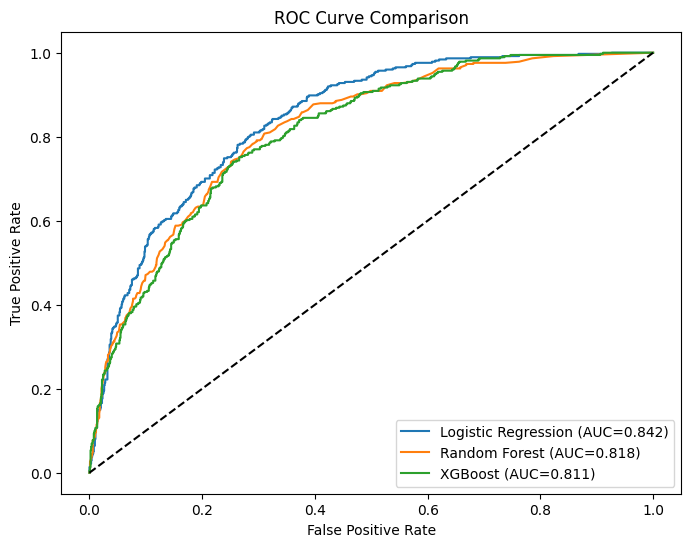

In [9]:
plt.figure(figsize=(8,6))

for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={results[name]['roc_auc']:.3f})")

plt.plot([0,1], [0,1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [10]:
best_model_name = max(results, key=lambda x: results[x]["roc_auc"])
best_model = results[best_model_name]["model"]

print("Best Model Selected:", best_model_name)

Best Model Selected: Logistic Regression


In [11]:
os.makedirs("models", exist_ok=True)
joblib.dump(best_model, "models/churn_model.pkl")

['models/churn_model.pkl']